# 1. Monte Carlo Paths for the Hull-White model

In Hull White model, sigma(t, T) = sigma * exp(-lambda*(T-t))

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):
    # time-step method for differentiation
    dt = 0.0001
    # Intantaneous forward rate
    f0T = lambda t: - (np.log(P0T(t+dt)) - np.log(P0T(t-dt))) / (2*dt)
    
    # Initial interest rate is a forward rate at time t -> 0
    r0 = f0T(0.00001)
    
    theta = lambda t: 1/lambd * (f0T(t+dt) - f0T(t-dt))/(2*dt) + f0T(t) + eta**2 / (2 * lambd**2) * (1 - np.exp(-2*lambd*t))
    
    Z = np.random.normal(0, 1, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    R = np.zeros([NoOfPaths, NoOfSteps + 1])
    R[:, 0] = r0
    time = np.zeros([NoOfSteps + 1])
    
    dt = T / float(NoOfSteps)
    
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
            
        W[:, i+1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        
        # Hull-White short rate model
        R[:, i+1] = R[:, i] + lambd*(theta(time[i]) - R[:, i])*dt + eta*(W[:, i+1] - W[:, i])
        
        time[i+1] = time[i] + dt
        
    # Outputs
    paths = {"time": time, "R": R}
    return paths

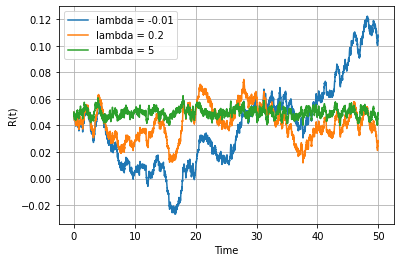

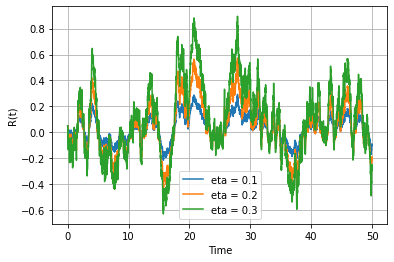

In [3]:
def mainCalculation():
    NoOfPaths = 1
    NoOfSteps = 5000
    T     = 50
    lambd = 0.5
    eta   = 0.01
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T)
    
    # Effect of mean reversion lambda
    plt.figure(1)
    legend = []
    lambdVec = [-0.01, 0.2, 5]
    
    for lambdTemp in lambdVec:
        np.random.seed(2)
        Paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambdTemp, eta)
        legend.append('lambda = {0}'.format(lambdTemp))
        timeGrid = Paths["time"]
        R = Paths["R"]
        plt.plot(timeGrid, np.transpose(R))
    
    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("R(t)")
    plt.legend(legend)
    
    # Effect of the volatility
    plt.figure(2)
    legend = []
    etaVec = [0.1, 0.2, 0.3]
    
    for etaTemp in etaVec:
        np.random.seed(2)
        Paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, etaTemp)
        legend.append('eta = {0}'.format(etaTemp))
        timeGrid = Paths["time"]
        R = Paths["R"]
        plt.plot(timeGrid, np.transpose(R))
        
    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("R(t)")
    plt.legend(legend)

mainCalculation()

# 2. Zero Coupon Bond (ZCB) using Hull-White model 

In [4]:
def f0T(t, P0T):
    # time-step needed for differentiation
    dt = 0.01    
    expr = - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    return expr

In [5]:
def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):
    # Initial interest rate is a forward rate at time t = 0
    r0 = f0T(0.01, P0T)
    
    theta = lambda t: 1/lambd * (f0T(t+dt,P0T) - f0T(t-dt,P0T))/(2*dt) + f0T(t,P0T) + eta**2 / (2 * lambd**2) * (1 - np.exp(-2*lambd*t))
    
    Z = np.random.normal(0, 1, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    R = np.zeros([NoOfPaths, NoOfSteps + 1])
    # Money saving account
    M = np.zeros([NoOfPaths, NoOfSteps + 1])
    
    M[:, 0] = 1
    R[:, 0] = r0
    time = np.zeros([NoOfSteps + 1])
    
    dt = T / float(NoOfSteps)
    
    for i in range(0, NoOfSteps):
        # Making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
            
        W[:, i+1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]
        
        # Hull-White short rate model
        R[:, i+1] = R[:, i] + lambd*(theta(time[i]) - R[:, i])*dt + eta*(W[:, i+1] - W[:, i])
        
        M[:, i+1] = M[:, i] * np.exp((R[:, i+1] + R[:, i])*0.5*dt)
        
        time[i+1] = time[i] + dt
    
    # Outputs
    paths = {"time": time, "R": R, "M": M}
    return paths

In [6]:
def HW_theta(lambd, eta, P0T):
    dt = 0.01
    
    theta = lambda t: 1/lambd * (f0T(t+dt) - f0T(t-dt))/(2*dt) + f0T(t) + eta**2 / (2 * lambd**2) * (1 - np.exp(-2*lambd*t))
    
    return theta

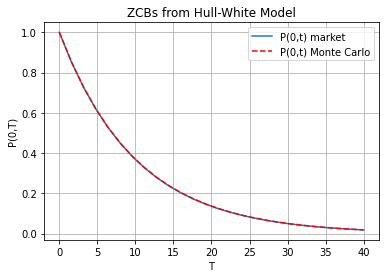

In [7]:
def mainCalculation():
    NoOfPaths = 20000
    NoOfSteps = 25
    
    lambd = 0.04
    eta = 0.01
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.1*T)
    
    # Initial r_0
    r0 = f0T(0.01, P0T)
    
    # In this experiment we compare ZCB from the market and MonteCarlo
    "Monte Carlo part"
    T = 40
    paths = GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta)
    M = paths["M"]
    ti = paths["time"]
    
    # Here we compare the price of an option on a ZCB from Monte Carlo and the market
    P_tMC = np.zeros([NoOfSteps + 1])
    for i in range(0, NoOfSteps + 1):
        P_tMC[i] = np.mean(1/M[:, i])
        
    plt.figure(1)
    plt.grid()
    plt.xlabel('T')
    plt.ylabel('P(0,T)')
    plt.plot(ti,P0T(ti))
    plt.plot(ti,P_tMC,'--r')
    plt.legend(['P(0,t) market','P(0,t) Monte Carlo'])
    plt.title('ZCBs from Hull-White Model')
    
mainCalculation()